<a href="https://colab.research.google.com/github/hache22/MarketBasketAnalytics/blob/main/MarketBasketAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción al Proyecto: Análisis de Cesta de Mercado

## Este notebook presenta un análisis de cesta de mercado (Market Basket Analysis) aplicado a los datos de ventas de "Sano y Fresco". **El objetivo principal es descubrir patrones de compra y relaciones entre los productos que adquieren los clientes.**

## Mediante la aplicación de algoritmos de reglas de asociación, busco identificar qué productos tienden a comprarse juntos. Esta información es invaluable para diversas estrategias comerciales, como:

*   **Optimización de la disposición en tienda:** Colocar productos que se compran juntos cerca uno del otro.
*   **Recomendaciones de productos:** Sugerir productos complementarios a los clientes durante su compra.
*   **Promociones cruzadas:** Crear ofertas que incluyan grupos de productos frecuentemente comprados juntos.
*   **Gestión de inventario:** Prever la demanda de productos basándose en la compra de otros artículos relacionados.

## El análisis se realizará a partir de los datos de transacciones almacenados en una base de datos SQLite. Se explorarán métricas clave como el soporte, la confianza y el lift para evaluar la fuerza e interés de las reglas de asociación encontradas.

### A continuación, se detallan los pasos seguidos en este análisis.


# Importacion de las Librerias
## SQLITE3 para manejo de las conexiones a la base de datos
## Pandas para manipulación y análisis de datos
## Importar la función combinations del módulo itertools para generar combinaciones de productos

In [2]:
# sqlite3 para interactuar con bases de datos SQLite
import sqlite3
from itertools import combinations
import pandas as pd

In [3]:
conexion = sqlite3.connect('sanoyfresco.db')

# Carga de los Datos provinientes de la base de datos "sanoyfresco.db"

### Cargar la tabla completa 'tickets' de la base de datos en un DataFrame de pandas

In [ ]:
df = pd.read_sql_query("SELECT * FROM tickets", conexion)

df

,id_pedido,id_cliente,fecha,hora,id_departamento,id_seccion,id_producto,nombre_producto,precio_unitario,cantidad,precio_total
0,1,112108,2023-02-02 00:00:00,10,4,83,49683,Pepino Kirby,0.99,4,3.96
1,1,112108,2023-02-02 00:00:00,10,4,24,13176,Bolsa de Bananas Orgánicas,2.45,4,9.80
2,1,112108,2023-02-02 00:00:00,10,4,24,47209,Aguacate Hass Orgánico,1.79,2,3.58
3,2,202279,2023-02-03 00:00:00,9,4,83,28985,Col Rizada Orgánica de Michigan,2.55,2,5.10
4,2,202279,2023-02-03 00:00:00,9,4,83,17794,Zanahorias,0.95,5,4.75
...,...,...,...,...,...,...,...,...,...,...,...
4975713,3421080,52726,2023-01-09 00:00:00,11,16,84,27845,Leche Entera Orgánica,0.99,3,2.97
4975714,3421080,52726,2023-01-09 00:00:00,11,4,83,41950,Racimo de Tomates Orgánicos,2.25,7,15.75
4975715,3421080,52726,2023-01-09 00:00:00,11,4,16,31717,Cilantro Orgánico,0.69,5,3.45
4975716,3421082,175185,2023-08-22 00:00:00,18,4,24,16797,Fresas,2.05,4,8.20


### Cerrar la conexión a la base de datos para liberar recursos

In [ ]:
conexion.close()

### Mostrando información sobre el DataFrame, incluyendo tipos de datos y valores no nulos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4975718 entries, 0 to 4975717
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id_pedido        int64  
 1   id_cliente       int64  
 2   fecha            object 
 3   hora             int64  
 4   id_departamento  int64  
 5   id_seccion       int64  
 6   id_producto      int64  
 7   nombre_producto  object 
 8   precio_unitario  float64
 9   cantidad         int64  
 10  precio_total     float64
dtypes: float64(2), int64(7), object(2)
memory usage: 417.6+ MB


# Calidad de los datos
<p> aca faltaria el proceso complementario de calidad de los datos, pero como no se trata de un documento laboral diario, se omite.


# Cambiando tipo de datos para la fecha
### Convertir la columna 'fecha' a tipo datetime para permitir operaciones basadas en tiempo

In [ ]:
df['fecha'] = pd.to_datetime(df['fecha'])

### Creando la cesta del usuario para proceder con el analisis en cuestion, se toman las columnas de id_pedido y nombre_producto para que esto sea fiel a la realidad
### El nuevo DataFrame 'df_cesta' contiene solo las columnas 'id_pedido' y 'nombre_producto'
### Esto se hace para preparar los datos para el análisis de la cesta de mercado

In [ ]:
df_cesta = df[['id_pedido','nombre_producto']]
df_cesta

,id_pedido,nombre_producto
0,1,Pepino Kirby
1,1,Bolsa de Bananas Orgánicas
2,1,Aguacate Hass Orgánico
3,2,Col Rizada Orgánica de Michigan
4,2,Zanahorias
...,...,...
4975713,3421080,Leche Entera Orgánica
4975714,3421080,Racimo de Tomates Orgánicos
4975715,3421080,Cilantro Orgánico
4975716,3421082,Fresas


## Acá agrupo los productos por 'id_pedido' y uní los nombres de los productos en una sola cadena separada por comas
### Esto crea una representación de cada pedido como una lista de productos comprados

In [ ]:
df_agrupado = df_cesta.groupby('id_pedido')['nombre_producto'].apply(lambda producto: ','.join(producto))
# Mostrar el resultado agrupado
df_agrupado

,nombre_producto
id_pedido,
1,"Pepino Kirby,Bolsa de Bananas Orgánicas,Aguaca..."
2,"Col Rizada Orgánica de Michigan,Zanahorias"
3,Espinacas Baby Orgánicas
5,"Bolsa de Bananas Orgánicas,Frambuesas Orgánica..."
10,"Banana,Cilantro Orgánico,Aguacate Orgánico,Ceb..."
...,...
3421077,"Frambuesas Orgánicas,Calabacín Orgánico,Leche ..."
3421078,"Manzanas Gala Orgánicas,Banana"
3421080,"Leche Entera Orgánica,Racimo de Tomates Orgáni..."


## Se aplica one-hot encoding a la serie agrupada
### Esto transforma cada cadena de productos en una fila donde cada columna representa un producto único
### Los valores son 1 si el producto está en el pedido y 0 si no lo está

In [ ]:
df_transacciones = df_agrupado.str.get_dummies(sep=',')
# Mostrar el DataFrame transformado
df_transacciones

,Agua con Gas de Pomelo,Aguacate Hass Orgánico,Aguacate Orgánico,Ajo Orgánico,Apio Orgánico en Ramillete Pequeño,Arándanos Orgánicos,Banana,Bolsa de Bananas Orgánicas,Calabacín Orgánico,Cebolla Amarilla Orgánica,...,Manzana Honeycrisp Orgánica,Manzanas Gala Orgánicas,Pepino Kirby,Pepino Orgánico,Racimo de Tomates Orgánicos,Rúcula Baby Orgánica,Tomates Cherry Orgánicos,Uvas Rojas sin Semillas,Zanahorias,Zanahorias Baby Orgánicas
id_pedido,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421077,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3421078,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3421080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Cálculo del soporte para cada producto (porcentaje de transacciones que contienen el producto)
### Esto lo hice calculando la media de cada columna (producto) en el DataFrame one-hot encoded y multiplicando por 100

In [ ]:
soporte = df_transacciones.mean() * 100
# Ordenar los productos por soporte de mayor a menor
soporte.sort_values(ascending=False)

,0
Banana,23.809381
Bolsa de Bananas Orgánicas,19.129710
Fresas Orgánicas,13.349170
Espinacas Baby Orgánicas,12.198935
Aguacate Hass Orgánico,10.703004
Aguacate Orgánico,8.929331
Limón Grande,7.791279
Fresas,7.241960
Limones,7.107944
Leche Entera Orgánica,6.918301


# Función para calcular la confianza entre dos productos (antecedente y consecuente)
### La confianza es la probabilidad de que se compre el consecuente dado que se compró el antecedente

In [ ]:
def confianza(antecedente, consecuente):
    # Filtro para las transacciones donde se compraron ambos productos (antecedente y consecuente)
    conjunto_ac = df_transacciones[(df_transacciones[antecedente] == 1) &
                                   (df_transacciones[consecuente] == 1)]
    # Calcular la confianza como el número de transacciones con ambos productos
    return len(conjunto_ac) / df_transacciones[antecedente].sum()

# Función para calcular el lift entre dos productos (antecedente y consecuente)
### El lift mide cuánto más probable es que se compre el consecuente dado que se compró el antecedente, en comparación con la probabilidad de comprar el consecuente de forma independiente

In [ ]:
def lift(antecedente, consecuente):
    # Calcular el soporte del antecedente
    soporte_a = df_transacciones[antecedente].mean()
    # Calcular el soporte del consecuente
    soporte_c = df_transacciones[consecuente].mean()
    # Contar el número de transacciones donde se compraron ambos productos
    conteo_ac = len(df_transacciones[(df_transacciones[antecedente] == 1) &
                                   (df_transacciones[consecuente] == 1)])
    # Calcular el soporte conjunto (probabilidad de comprar ambos productos)
    soporte_ac = conteo_ac / len(df_transacciones)
    # Calcular el lift como el soporte conjunto dividido por el producto de los soportes individuales
    return soporte_ac / (soporte_a * soporte_c)

In [ ]:
umbral_confianza = 0.05
asociaciones = []

# Iterar a través de todas las combinaciones de dos productos en el DataFrame de transacciones
for antecedente, consecuente in combinations(df_transacciones.columns, 2):

    # Calcular el soporte del antecedente
    soporte_a = df_transacciones[antecedente].mean()

    # Calcular la confianza entre el antecedente y el consecuente
    conf = confianza(antecedente, consecuente)
    # Si la confianza es mayor que el umbral definido, considerar esta combinación como una posible regla de asociación
    if conf > umbral_confianza:
        # Calcular el lift para la combinación
        lift_valor = lift(antecedente, consecuente)
        # Agregar la información de la regla de asociación a la lista
        asociaciones.append({
            'antecedente': antecedente,
            'consecuente': consecuente,
            'soporte_a': round(soporte_a * 100,1), # Soporte del antecedente
            'confianza': round(conf * 100,1), # Confianza en porcentaje
            'lift': round(lift_valor,1) # Valor del lift
        })


# Conversion de la lista de diccionarios de asociaciones en un DataFrame de pandas
df_asociaciones = pd.DataFrame(asociaciones)

# Ordenar el DataFrame de reglas de asociación por el valor de lift de mayor a menor
df_asociaciones.sort_values(by='lift', ascending=False, inplace=True)

# Mostrar el DataFrame con las reglas de asociación encontradas, ordenadas por lift
df_asociaciones

,antecedente,consecuente,soporte_a,confianza,lift
185,Cebolla Roja Orgánica,Cilantro Orgánico,3.4,12.8,3.6
224,Cilantro Orgánico,Limones,3.5,25.4,3.6
61,Ajo Orgánico,Cebolla Amarilla Orgánica,5.5,20.1,3.5
106,Apio Orgánico en Ramillete Pequeño,Zanahorias,3.4,12.0,3.3
102,Apio Orgánico en Ramillete Pequeño,Pepino Orgánico,3.4,12.7,3.1
...,...,...,...,...,...
136,Bolsa de Bananas Orgánicas,Limón Grande,19.1,5.2,0.7
38,Aguacate Orgánico,Bolsa de Bananas Orgánicas,8.9,13.0,0.7
58,Ajo Orgánico,Banana,5.5,17.4,0.7
3,Agua con Gas de Pomelo,Bolsa de Bananas Orgánicas,3.8,13.2,0.7


## Se Genera una tabla de los productos únicos con su 'id_producto', 'id_seccion', 'id_departamento' para enriquecer la tabla de reglas
## Para mas comodidad, se crea un nuevo DataFrame 'productos_unicos' que contiene información sobre cada producto único
### Se seleccionan las columnas 'id_producto', 'id_seccion', 'id_departamento' y 'nombre_producto'
### drop_duplicates() se usa para asegurarse de que cada producto aparezca solo una vez

In [ ]:
productos_unicos = df[['id_producto', 'id_seccion', 'id_departamento', 'nombre_producto']].drop_duplicates()

# DataFrame de productos únicos
productos_unicos

,id_producto,id_seccion,id_departamento,nombre_producto
0,49683,83,4,Pepino Kirby
1,13176,24,4,Bolsa de Bananas Orgánicas
2,47209,24,4,Aguacate Hass Orgánico
3,28985,83,4,Col Rizada Orgánica de Michigan
4,17794,83,4,Zanahorias
5,21903,123,4,Espinacas Baby Orgánicas
7,27966,123,4,Frambuesas Orgánicas
9,24852,24,4,Banana
10,31717,16,4,Cilantro Orgánico
11,47766,24,4,Aguacate Orgánico


# Opto por enriquecer el DataFrame de reglas de asociación 'df_asociaciones' con información del antecedente
## Se realiza una fusión (merge) con el DataFrame 'productos_unicos' utilizando el nombre del producto como clave
### Se utiliza un left merge para mantener todas las reglas de asociación y agregar la información del producto correspondiente al antecedente

In [ ]:
df_asociaciones_enriquecido = df_asociaciones.merge(productos_unicos, left_on='antecedente', right_on='nombre_producto', how='left').drop(columns=['nombre_producto'])
# Renombrar las columnas para reflejar que la información añadida corresponde al antecedente
df_asociaciones_enriquecido.columns = ['antecedente', 'consecuente', 'soporte_a', 'confianza', 'lift', 'id_producto_a', 'id_seccion_a', 'id_departamento_a']
# Mostrar el DataFrame de reglas de asociación enriquecido
df_asociaciones_enriquecido

,antecedente,consecuente,soporte_a,confianza,lift,id_producto_a,id_seccion_a,id_departamento_a
0,Cebolla Roja Orgánica,Cilantro Orgánico,3.4,12.8,3.6,8518,83,4
1,Cilantro Orgánico,Limones,3.5,25.4,3.6,31717,16,4
2,Ajo Orgánico,Cebolla Amarilla Orgánica,5.5,20.1,3.5,24964,83,4
3,Apio Orgánico en Ramillete Pequeño,Zanahorias,3.4,12.0,3.3,44359,83,4
4,Apio Orgánico en Ramillete Pequeño,Pepino Orgánico,3.4,12.7,3.1,44359,83,4
...,...,...,...,...,...,...,...,...
394,Bolsa de Bananas Orgánicas,Limón Grande,19.1,5.2,0.7,13176,24,4
395,Aguacate Orgánico,Bolsa de Bananas Orgánicas,8.9,13.0,0.7,47766,24,4
396,Ajo Orgánico,Banana,5.5,17.4,0.7,24964,83,4
397,Agua con Gas de Pomelo,Bolsa de Bananas Orgánicas,3.8,13.2,0.7,44632,115,7


# Carga de las reglas generadas en un archivo CSV, posteriormente se utiliza este mismo en secciones como marketing o desarrollo para ser explotado al maximo.


In [ ]:
df_asociaciones_enriquecido.to_csv('reglas.csv', index=False, sep=';', decimal=',')

# Visualizaciones


## Se crea un gráfico de barras de los N productos principales por soporte utilizando la variable `soporte` para visualizar los productos más frecuentes.



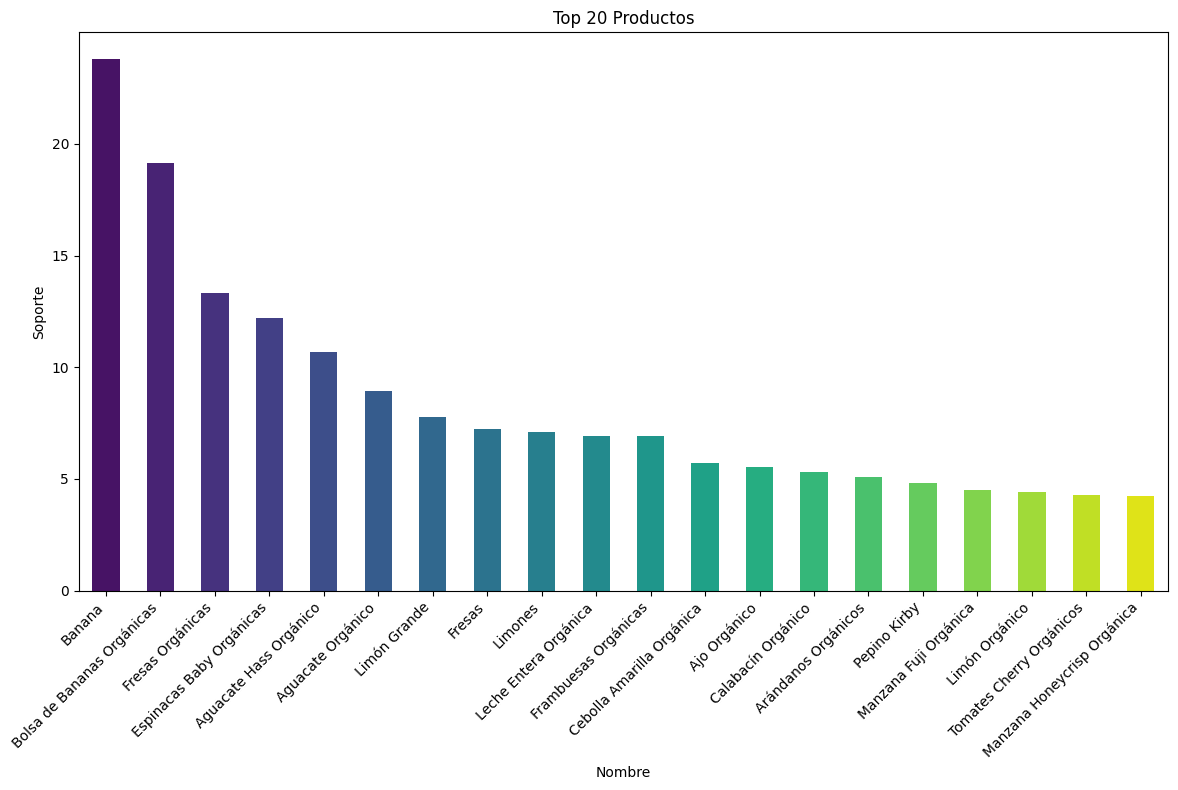

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# visualizacion de top 20 productos
plt.figure(figsize=(12, 8))
soporte.sort_values(ascending=False).head(20).plot(kind='bar', color=sns.color_palette('viridis', 20))
plt.title('Top 20 Productos')
plt.xlabel('Nombre')
plt.ylabel('Soporte')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Generé un diagrama de dispersión para explorar la relación entre la confianza y la elevación del DataFrame `df_asociaciones`.



# Paso a crear visualizaciones para mostrar la distribución de antecedentes y consecuentes por departamento utilizando el DataFrame `df_asociaciones_enriquecido`.
## Se genera un diagrama de dispersión para explorar la relación entre la confianza y la elevación
### Este diagrama de dispersión visualiza la relación entre la confianza y la elevación de las reglas de asociación generadas.
### La confianza indica la probabilidad de que el consecuente se compre dado el antecedente, mientras que la elevación muestra la mayor probabilidad de que el consecuente se compre cuando el antecedente también se compra, en comparación con su probabilidad base.
### El tamaño y el color de los puntos representan el apoyo del antecedente. Las reglas con mayor elevación y confianza, especialmente aquellas con mayor apoyo, suelen ser más interesantes y prácticas.

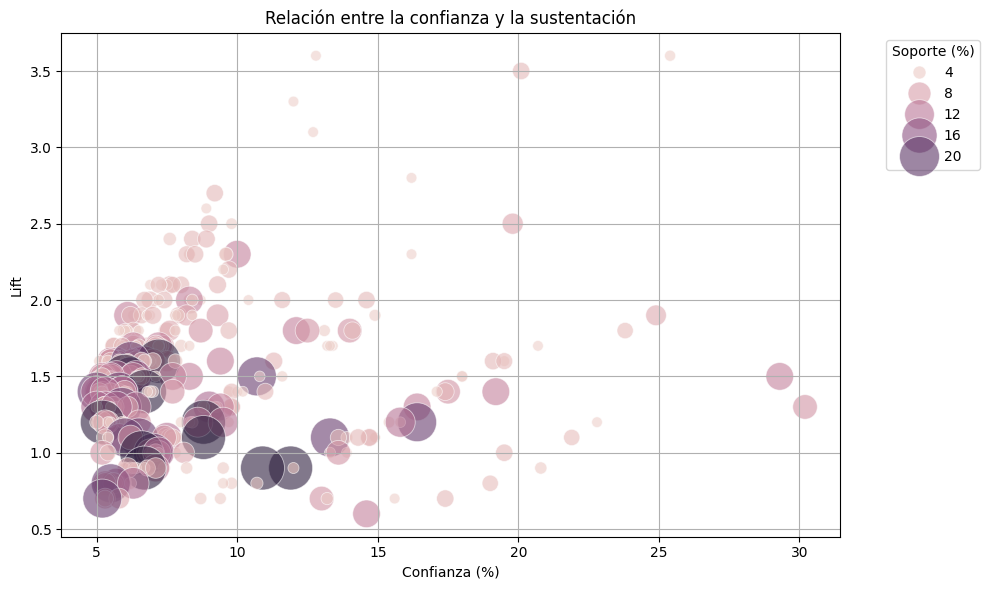

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_asociaciones, x='confianza', y='lift', size='soporte_a', hue='soporte_a', sizes=(50, 1000), alpha=0.6)
plt.title('Relación entre la confianza y la sustentación')
plt.xlabel('Confianza (%)')
plt.ylabel('Lift')
plt.grid(True)
plt.legend(title='Soporte (%)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Ahora genero gráficos de barras para explorar la distribución de productos únicos en diferentes departamentos y secciones



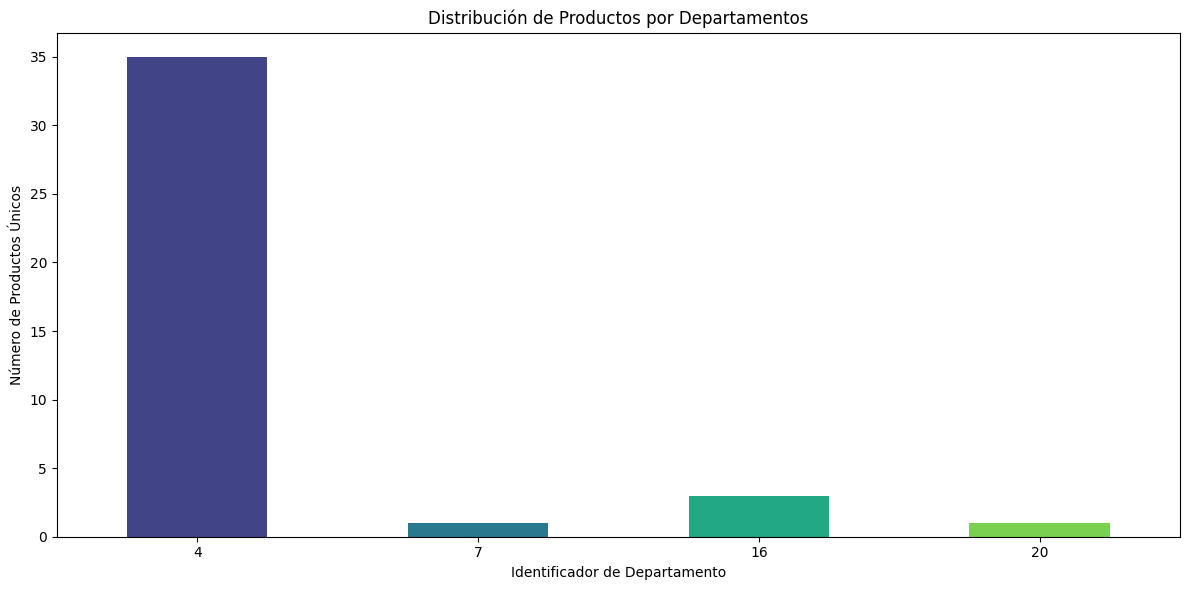

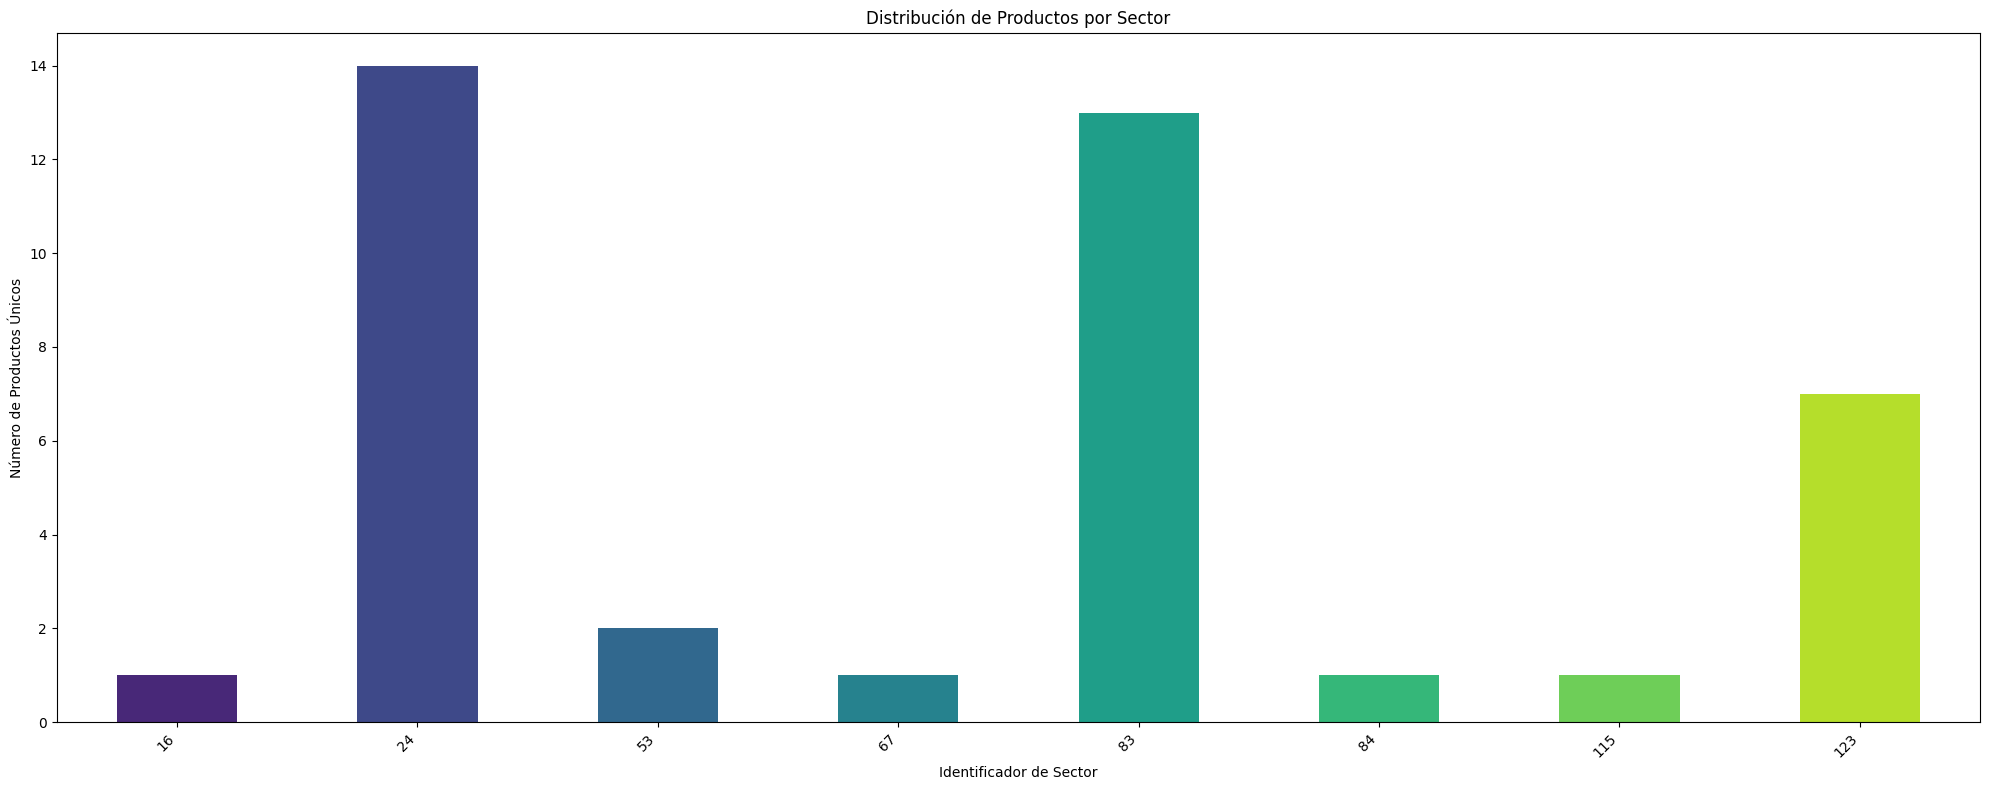

In [ ]:
# Distribucion por Departamentos
plt.figure(figsize=(12, 6))
productos_unicos['id_departamento'].value_counts().sort_index().plot(kind='bar', color=sns.color_palette('viridis', len(productos_unicos['id_departamento'].unique())))
plt.title('Distribución de Productos por Departamentos')
plt.xlabel('Identificador de Departamento')
plt.ylabel('Número de Productos Únicos')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Distribucion por Sector
plt.figure(figsize=(20, 8))
productos_unicos['id_seccion'].value_counts().sort_index().plot(kind='bar', color=sns.color_palette('viridis', len(productos_unicos['id_seccion'].unique())))
plt.title('Distribución de Productos por Sector')
plt.xlabel('Identificador de Sector')
plt.ylabel('Número de Productos Únicos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()